In [1]:
from datetime import datetime
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from neo4j import GraphDatabase

from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.manifold import TSNE

from umap import UMAP

import torch
from torch.nn import Linear, MSELoss
import torch.nn.functional as F

from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.transforms import RandomLinkSplit, ToUndirected, AddSelfLoops, NormalizeFeatures

from utils import preprocess_neo4j_db
from neo4_connection import USER, PWD, URL

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
driver = GraphDatabase.driver(uri=URL, auth=(USER, PWD))

def fetch_data(query):
  with driver.session() as session:
    result = session.run(query)
    return pd.DataFrame([r.values() for r in result], columns=result.keys())

### Preporcess neo4j database

In [4]:
preprocess_neo4j_db(file_path='./neo4j_cypher_queries/01_db_preprocessing.txt')

### Get data from neo4j

In [5]:
user_query = """
MATCH (u:User)
RETURN u.userId AS userId
"""

user_df = fetch_data(user_query)
print(user_df.shape)
user_df.head()

(671, 1)


,userId
0,1
1,2
2,3
3,4
4,5


In [6]:
# Unforunately there are too many null values in revenue and budged. Hence I do not use them as features.
movie_query = """
MATCH (m:Movie)
RETURN m.movieId AS movieId,
    m.imdbRating AS imdbRating,
    m.imdbVotes AS imdbVotes,
    m.runtime AS runtime,
    m.year AS year,
    m.genreEmbedding AS genreEmbedding,
    m.title AS title,
    m.plot AS plot
"""

movie_df = fetch_data(movie_query)
print(movie_df.shape)
movie_df.head()

(9125, 8)


,movieId,imdbRating,imdbVotes,runtime,year,genreEmbedding,title,plot
0,1,8.3,591836.0,81.0,1995.0,"[0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",Toy Story,A cowboy doll is profoundly threatened and jea...
1,2,6.9,198355.0,104.0,1995.0,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",Jumanji,When two kids find and play a magical board ga...
2,3,6.6,18615.0,101.0,1995.0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Grumpier Old Men,John and Max resolve to save their beloved bai...
3,4,5.6,7210.0,124.0,1995.0,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",Waiting to Exhale,"Based on Terry McMillan's novel, this film fol..."
4,5,5.9,25938.0,106.0,1995.0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Father of the Bride Part II,"In this sequel, George Banks deals not only wi..."


In [7]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movieId         9125 non-null   int64  
 1   imdbRating      9058 non-null   float64
 2   imdbVotes       9055 non-null   float64
 3   runtime         9062 non-null   float64
 4   year            9096 non-null   float64
 5   genreEmbedding  9125 non-null   object 
 6   title           9125 non-null   object 
 7   plot            9083 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 570.4+ KB


In [8]:
rating_query = """
MATCH (u:User) -[r:RATED]-> (m:Movie)
RETURN u.userId AS userId,
    m.movieId AS movieId,
    r.rating AS rating
"""

rating_df = fetch_data(rating_query)
print(rating_df.shape)
rating_df.head()

(100004, 3)


,userId,movieId,rating
0,1,1343,2.0
1,1,1339,3.5
2,1,1405,1.0
3,1,1371,2.5
4,1,1263,2.0


### Data cleansing

Pandas stores the genre embeddings as list. We have to transform the list column into multiple columns. So that each column represents a genre with possible with boolean values. Furthermore we have to embed the title and the movie plot. I use the library sentence transformers.

SentenceTransformers is a Python framework for state-of-the-art sentence, text and image embeddings. 

#### Genre Embeddings

In [9]:
query = """
MATCH(g:Genre)
WITH g ORDER BY g.name
RETURN g.name AS header
"""

header_df = fetch_data(query)
genre_headers = header_df['header'].to_list()

In [10]:
genre_embed = np.array(movie_df['genreEmbedding'].values.tolist())
print('Genre Embedding shape:', genre_embed.shape)
assert genre_embed.shape == (9125, 20), 'Shape missmatrch'

Genre Embedding shape: (9125, 20)


In [11]:
genre_df = pd.DataFrame(genre_embed, columns=genre_headers)
genre_df.shape

(9125, 20)

In [12]:
movie_df = pd.concat([movie_df, genre_df], axis=1)
movie_df.shape

(9125, 28)

In [13]:
movie_df.drop(columns=['genreEmbedding', '(no genres listed)'], axis=1, inplace=True)
print(movie_df.shape)
# movie_df.head(20)

(9125, 26)


#### Title and plot embedding

In [14]:
movie_df[['movieId', 'title', 'plot']]

,movieId,title,plot
0,1,Toy Story,A cowboy doll is profoundly threatened and jea...
1,2,Jumanji,When two kids find and play a magical board ga...
2,3,Grumpier Old Men,John and Max resolve to save their beloved bai...
3,4,Waiting to Exhale,"Based on Terry McMillan's novel, this film fol..."
4,5,Father of the Bride Part II,"In this sequel, George Banks deals not only wi..."
...,...,...,...
9120,162672,Mohenjo Daro,A period adventure and love story set during t...
9121,163056,Shin Godzilla,Japan is plunged into chaos upon the appearanc...
9122,163949,The Beatles: Eight Days a Week - The Touring Y...,A compilation of found footage featuring music...
9123,164977,The Gay Desperado,"Chivo, a singer who works in a movie theater p..."


In [15]:
movie_df.loc[111, 'plot']

'Two melancholy Hong Kong policemen fall in love: one with a mysterious female underworld figure, the other with a beautiful and ethereal server at a late-night restaurant he frequents.'

In [16]:
# 42 plots are missing. If the plot is missing I will fill it with the title
movie_df[['plot']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   plot    9083 non-null   object
dtypes: object(1)
memory usage: 71.4+ KB


In [17]:
# Index 510 has an empty plot and is now filled with the movie title

movie_df['plot'] = np.where(movie_df['plot'].isnull(), movie_df['title'], movie_df['plot'])
movie_df.loc[508:512, 'plot']

508    A group of women of Indian descent take a trip...
509    A young boy is bequeathed the ownership of a p...
510                                    Wedding Gift, The
511    Marco Sperelli is a teacher, he is divorced an...
512    Raymond Aibelli is a promising medical student...
Name: plot, dtype: object

In [18]:
sentences = movie_df['plot'].to_list()
print('# of sentences:', len(sentences))
assert len(sentences) == len(movie_df), 'Shape missmatch. Check if there are any null-values in the plot.'

# of sentences: 9125


In [19]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
plot_embeddings = model.encode(sentences)
plot_embeddings.shape, plot_embeddings[0]

((9125, 384),
 array([-2.83514298e-02, -1.84655376e-02,  4.55664992e-02, -6.73980918e-03,
         1.58164604e-03, -2.34077089e-02,  1.52290221e-02,  2.85078455e-02,
        -4.91095707e-02,  3.20482031e-02,  2.33482849e-02, -1.17351336e-03,
         8.34142640e-02, -3.13076228e-02,  1.41747463e-02,  2.72149127e-02,
         8.89891088e-02,  3.35503109e-02, -2.32784692e-02, -2.24349964e-02,
         7.29824416e-03, -1.45680746e-02, -4.11115587e-02,  4.98188585e-02,
        -6.84763268e-02, -3.73839960e-02, -7.91816972e-03,  5.27191423e-02,
        -2.73374096e-02,  9.30573419e-03, -2.34319754e-02, -3.87955345e-02,
         8.19623098e-03, -4.21063742e-03, -4.58212948e-04,  1.00464188e-01,
        -2.23493204e-02, -8.55326355e-02,  3.25274803e-02, -5.50645739e-02,
        -5.26372604e-02,  3.42741306e-03, -1.61870581e-03,  2.46253964e-02,
        -6.68734908e-02, -5.77454269e-02, -1.73136394e-03, -2.82837097e-02,
         6.21164292e-02, -4.54500206e-02, -4.72014882e-02, -1.29756713e-02

In [20]:
movie_df.drop(columns=['title', 'plot'], axis=1, inplace=True)
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movieId      9125 non-null   int64  
 1   imdbRating   9058 non-null   float64
 2   imdbVotes    9055 non-null   float64
 3   runtime      9062 non-null   float64
 4   year         9096 non-null   float64
 5   Action       9125 non-null   int32  
 6   Adventure    9125 non-null   int32  
 7   Animation    9125 non-null   int32  
 8   Children     9125 non-null   int32  
 9   Comedy       9125 non-null   int32  
 10  Crime        9125 non-null   int32  
 11  Documentary  9125 non-null   int32  
 12  Drama        9125 non-null   int32  
 13  Fantasy      9125 non-null   int32  
 14  Film-Noir    9125 non-null   int32  
 15  Horror       9125 non-null   int32  
 16  IMAX         9125 non-null   int32  
 17  Musical      9125 non-null   int32  
 18  Mystery      9125 non-null   int32  
 19  Romanc

In [21]:
movie_df['imdbRating'].fillna(movie_df['imdbRating'].mean(), inplace=True)
movie_df['imdbVotes'].fillna(movie_df['imdbVotes'].mean(), inplace=True)
movie_df['runtime'].fillna(movie_df['runtime'].mean(), inplace=True)
movie_df['year'].fillna(movie_df['year'].mean(), inplace=True)

assert not movie_df.isnull().values.any(), 'Null values in dataset!'

In [22]:
print('Movie DF shape:', movie_df.shape, '\nEmbeddings shape:', plot_embeddings.shape)

Movie DF shape: (9125, 24) 
Embeddings shape: (9125, 384)


### Reduce Plot Embedding Dimensionality

The pretrained hugging-face NLP model returns Emdeddings of 384 dimensions. Compared to 24 dimensional movie embedding (genres, runtime, year, etc.), it seems that the plot embedding is overweighted. Here we try different dimensionalty reduction methods such as t-SNE and U-Map. 

In [23]:
print('Compute t-SNE manifold reduction (2D)....')
tsne_2d = TSNE(n_components=2, perplexity=19, init='random', learning_rate='auto')
plot_embed_tsne_reduced_2d = tsne_2d.fit_transform(plot_embeddings)

print('Compute u-Map manifold reduction (2D)....')
umap_2d = UMAP(n_neighbors=15, n_components=2, init='random', random_state=11)
plot_embed_umap_reduced_2d = umap_2d.fit_transform(plot_embeddings)

print('Compute u-Map manifold reduction (4D)....')
umap_4d = UMAP(n_neighbors=15, n_components=4, init='random', random_state=11)
plot_embed_umap_reduced_4d = umap_4d.fit_transform(plot_embeddings)

print('Compute u-Map manifold reduction (8D)....')
umap_8d = UMAP(n_neighbors=15, n_components=8, init='random', random_state=11)
plot_embed_umap_reduced_8d = umap_8d.fit_transform(plot_embeddings)

print('t-SNE (2D) shape:', plot_embed_tsne_reduced_2d.shape)
print('u-Map (2D) shape:', plot_embed_umap_reduced_2d.shape)
print('t-SNE (4D) shape:', plot_embed_umap_reduced_4d.shape)
print('t-SNE (8D) shape:', plot_embed_umap_reduced_8d.shape)

Compute t-SNE manifold reduction (2D)....
Compute u-Map manifold reduction (2D)....
Compute u-Map manifold reduction (4D)....
Compute u-Map manifold reduction (8D)....
t-SNE (2D) shape: (9125, 2)
u-Map (2D) shape: (9125, 2)
t-SNE (4D) shape: (9125, 4)
t-SNE (8D) shape: (9125, 8)


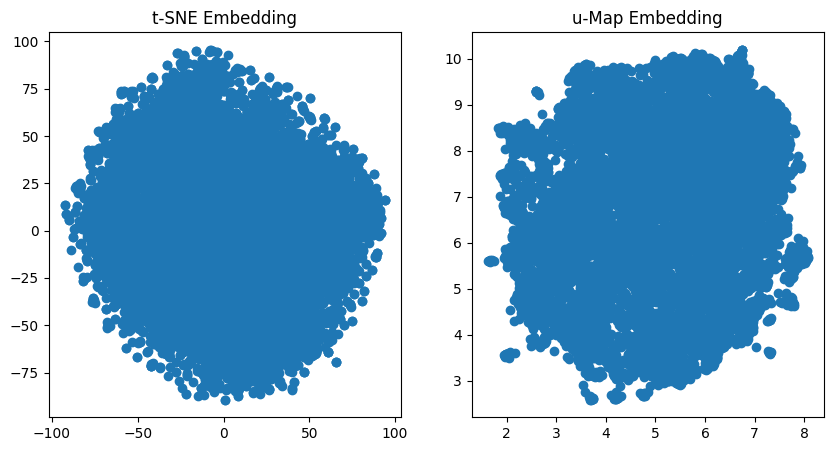

In [24]:
_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax0.scatter(plot_embed_tsne_reduced_2d[:,0], plot_embed_tsne_reduced_2d[:,1])
ax0.set_title('t-SNE Embedding')
ax1.scatter(plot_embed_umap_reduced_2d[:,0], plot_embed_umap_reduced_2d[:,1])
ax1.set_title('u-Map Embedding')
plt.show()

### Encoding & Scaling data

In [25]:
user_encoder, movie_encoder = LabelEncoder(), LabelEncoder()
scaler = StandardScaler()

In [26]:
user_df['userId'] = user_encoder.fit_transform(user_df['userId'])
movie_df['movieId'] = movie_encoder.fit_transform(movie_df['movieId'])

rating_df['userId'] = user_encoder.transform(rating_df['userId'])
rating_df['movieId'] = movie_encoder.transform(rating_df['movieId'])

In [27]:
features_to_scale = ['imdbRating', 'imdbVotes', 'runtime', 'year']
scaled_features = scaler.fit_transform(movie_df[features_to_scale])
scaled_features_df = pd.DataFrame(scaled_features, columns=features_to_scale)

In [28]:
movie_df.drop(columns=features_to_scale, axis=1, inplace=True)
movie_df = pd.concat([movie_df, scaled_features_df], axis=1)
movie_df.head()

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,imdbRating,imdbVotes,runtime,year
0,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,1.528928,5.144229,-0.876122,0.158905
1,1,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0.174897,1.394602,-0.058951,0.158905
2,2,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,-0.115253,-0.318207,-0.165539,0.158905
3,3,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,-1.082418,-0.426889,0.651632,0.158905
4,4,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,-0.792268,-0.248423,0.012107,0.158905


In [29]:
movie_df.describe()

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,imdbRating,imdbVotes,runtime,year
count,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,...,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9125.000000,9.125000e+03,9.125000e+03,9.125000e+03,9.125000e+03
mean,4562.000000,0.169315,0.122411,0.048986,0.063890,0.363288,0.120548,0.054247,0.478356,0.071671,...,0.059507,0.169315,0.086795,0.189479,0.040219,0.018411,7.697222e-16,3.114708e-18,-1.993413e-16,-5.095662e-15
std,2634.304937,0.375051,0.327778,0.215851,0.244571,0.480973,0.325619,0.226516,0.499559,0.257957,...,0.236584,0.375051,0.281549,0.391910,0.196484,0.134439,1.000055e+00,1.000055e+00,1.000055e+00,1.000055e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.951079e+00,-4.954719e-01,-3.682925e+00,-4.650468e+00
25%,2281.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.988353e-01,-4.503885e-01,-4.497720e-01,-3.582321e-01
50%,4562.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.818045e-02,-3.532937e-01,-1.300096e-01,2.623321e-01
75%,6843.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.551962e-01,0.000000e+00,3.318695e-01,7.277552e-01
max,9124.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.786243e+00,1.500774e+01,2.857755e+01,1.244892e+00


In [30]:
# saving
safe_date = datetime.now().strftime('%Y%m%d')
base_path = f'./datasets/{safe_date}'

np.save(f'{base_path}_np_plot_embeddings.npy', plot_embeddings)
np.save(f'{base_path}_np_plot_tsne_2d_embeddings.npy', plot_embed_tsne_reduced_2d)
np.save(f'{base_path}_np_plot_umap_2d_embeddings.npy', plot_embed_umap_reduced_2d)
np.save(f'{base_path}_np_plot_umap_4d_embeddings.npy', plot_embed_umap_reduced_4d)
np.save(f'{base_path}_np_plot_umap_8d_embeddings.npy', plot_embed_umap_reduced_8d)
np.save(f'{base_path}_np_movie_array.npy', movie_df.values)

### Create Pytorch Geometric (heterogenious) Dataset

In [31]:
def create_hetero_dataset(plot_embedding:np.array) -> dict:
    x_user = torch.eye(len(user_df['userId'].values))
    # print('x_user:', x_user.size())

    x_movie = movie_df.drop(columns=['movieId'], axis=1)
    x_movie = x_movie.values
    # x_movie = np.concatenate((x_movie, embeddings), axis=1)
    
    if plot_embedding is not None:
        x_movie = np.concatenate((x_movie, plot_embedding), axis=1)
    x_movie = torch.Tensor(x_movie)
    x_movie.size()

    edge_index = torch.Tensor(rating_df[['userId', 'movieId']].values).swapaxes(1,0).to(torch.long)
    edge_index.size(), edge_index

    edge_label = torch.Tensor(rating_df['rating'].values)
    edge_label.size(), edge_label

    data = HeteroData()
    data['user'].x = x_user
    data['movie'].x = x_movie

    data[('user', 'rates', 'movie')].edge_index = edge_index
    data[('user', 'rates', 'movie')].edge_label = edge_label

    data = ToUndirected()(data)
    del data[('movie', 'rev_rates', 'user')].edge_label
    
    data = data.to(device)
    print(data)

    return data

In [32]:
data = create_hetero_dataset(plot_embedding=None)

HeteroData(
  user={ x=[671, 671] },
  movie={ x=[9125, 23] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100004] }
)


### Train / Test Split

### GNN Model

In [33]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # these convolutions have been replicated to match the number of edge types
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        # self.lin2 = Linear(hidden_channels, hidden_channels)    # new
        self.lin_out = Linear(hidden_channels, 1)
        
    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        # concat user and movie embeddings
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)
        # concatenated embeddings passed to linear layer
        z = self.lin1(z).relu()
        # z = self.lin2(z).relu()    #new
        z = self.lin_out(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        # z_dict contains dictionary of movie and user embeddings returned from GraphSage
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


# model = Model(hidden_channels=64).to(device)

In [34]:
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    # loss = weighted_mse_loss(pred, target, weight)
    loss = F.mse_loss(pred, target).sqrt()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [35]:
comp_val_losses = []
for embed in [None, plot_embeddings, plot_embed_tsne_reduced_2d, plot_embed_umap_reduced_2d, 
             plot_embed_umap_reduced_4d, plot_embed_umap_reduced_8d]:
    if embed is None:
        print('Without plot embeddings.')
    else:
        print(embed.shape)
    
    data = create_hetero_dataset(embed)

    # Train/Test Splitting
    train_data, val_data, test_data = RandomLinkSplit(
        num_val=0.1,
        num_test=0.1,
        neg_sampling_ratio=0.0,
        edge_types=[('user', 'rates', 'movie')],
        rev_edge_types=[('movie', 'rev_rates', 'user')],
    )(data)

    # Model
    model = Model(hidden_channels=64).to(device)

    # Lazy init
    with torch.no_grad():
        model.encoder(train_data.x_dict, train_data.edge_index_dict)

    optimizer = torch.optim.Adam(model.parameters())

    # Training
    EPOCHS = 300
    train_losses, val_losses, test_losses = [], [], []
    for epoch in range(1, EPOCHS+1):
        train_loss = train()
        # train_rmse = test(train_data)
        val_rmse = test(val_data)
        test_rmse = test(test_data)
        
        train_losses.append(train_loss), val_losses.append(val_rmse), test_losses.append(test_rmse)
        
        print(f'Epoch: {epoch:03d}\tTrain: {train_loss:.4f}\t'
            f'Val: {val_rmse:.4f}\tTest: {test_rmse:.4f}')

    comp_val_losses.append(val_losses)

Without plot embeddings.
HeteroData(
  user={ x=[671, 671] },
  movie={ x=[9125, 23] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100004] }
)
Epoch: 001	Train: 3.7028	Val: 3.6274	Test: 3.6276
Epoch: 002	Train: 3.6300	Val: 3.5519	Test: 3.5519
Epoch: 003	Train: 3.5539	Val: 3.4734	Test: 3.4732
Epoch: 004	Train: 3.4747	Val: 3.3901	Test: 3.3898
Epoch: 005	Train: 3.3908	Val: 3.2988	Test: 3.2985
Epoch: 006	Train: 3.2989	Val: 3.1977	Test: 3.1972
Epoch: 007	Train: 3.1970	Val: 3.0853	Test: 3.0848
Epoch: 008	Train: 3.0838	Val: 2.9604	Test: 2.9597
Epoch: 009	Train: 2.9579	Val: 2.8217	Test: 2.8210
Epoch: 010	Train: 2.8183	Val: 2.6683	Test: 2.6675
Epoch: 011	Train: 2.6637	Val: 2.4992	Test: 2.4983
Epoch: 012	Train: 2.4933	Val: 2.3138	Test: 2.3128
Epoch: 013	Train: 2.3065	Val: 2.1127	Test: 2.1117
Epoch: 014	Train: 2.1037	Val: 1.8986	Test: 1.8975
Epoch: 015	Train: 1.8878	Val: 1.6782	Test: 1.6774
Epoch: 016	Train: 1.6660

In [36]:
len(comp_val_losses), len(comp_val_losses[0])

(6, 300)

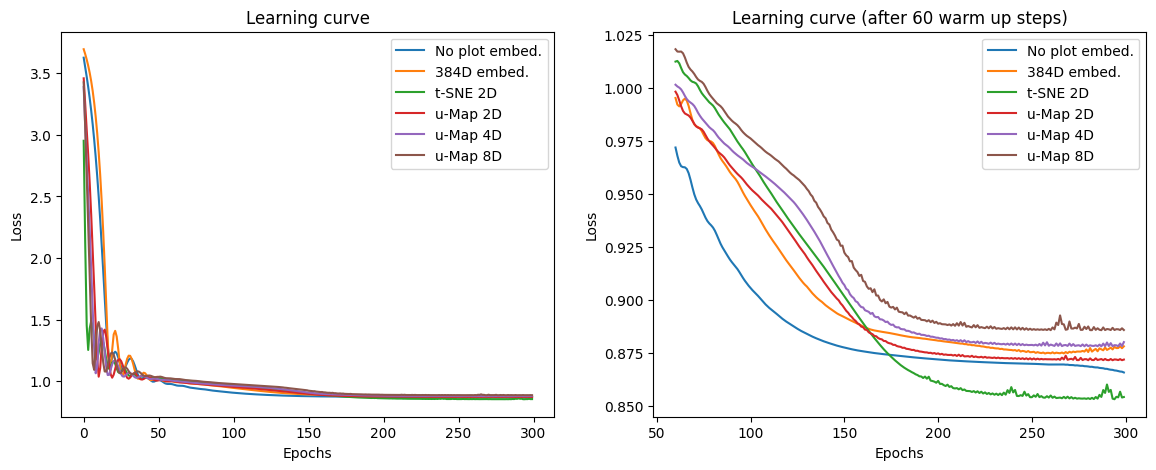

In [37]:
SKIP_WARM_UP_STEPS = 60

maps = ['No plot embed.', '384D embed.', 't-SNE 2D', 'u-Map 2D', 'u-Map 4D', 'u-Map 8D']

_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
for i, label in enumerate(maps):
    ax0.plot(comp_val_losses[i], label=label)
    ax1.plot(range(SKIP_WARM_UP_STEPS, len(comp_val_losses[0])), comp_val_losses[i][SKIP_WARM_UP_STEPS:], label=label)

ax0.set_title('Learning curve')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Loss')
ax0.legend()

ax1.set_title(f'Learning curve (after {SKIP_WARM_UP_STEPS} warm up steps)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
plt.show()